It's the same sample of "[Convolutional Neural Networks](https://github.com/annemacena/pytorch-crash-course/blob/master/Convolutional_Neural_Networks.ipynb)" but testing the [CIFAR 10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset

In [1]:
!pip3 install torch torchvision

In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
'''
  * transforms.ToTensor() will convert the numpy array (with a range of 0 to 255) to a float tensor (with the range of 0 to 1)

  * transforms.Normalize((0.5,), (0.5,)) specifies the mean and the deviation that would be used to normalize all channels of the tensor image
      Normalization does the following for each channel: image = (image - mean) / std.
      The value 0.5 was choose in this case cause the autor wanted to normalize the image in the range [-1,1].
      For example, the minimum value 0 will be converted to (0-0.5)/0.5=-1, the maximum value of 1 will be converted to (1-0.5)/0.5=1.

      Normalization helps reducing the skewness and distortions.
'''
transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

'''
  The DataLoader combine a dataset object along with different samplers (different strategies for providing data to algorithms) 
  and provides a batch (set of samples used in a interaction) of images.

  * gradient descent algorithms tend to get stuck in local minima, 
    so if you suffle your training data, you ensure that the subset changes with every single iterations.
'''
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

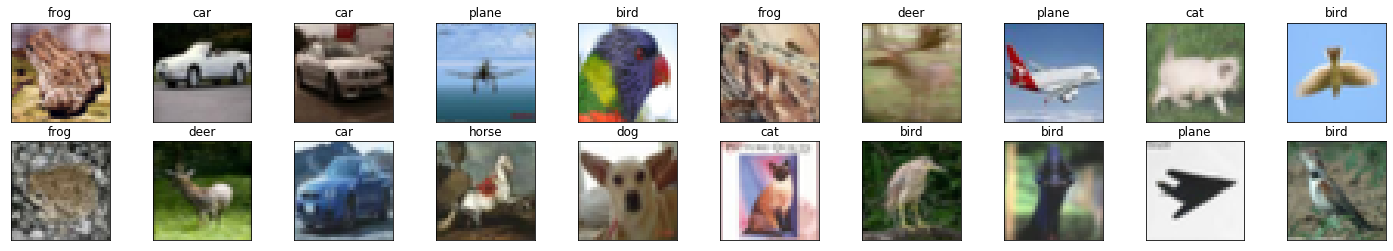

In [7]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [0]:
class LeNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 20, 5, 1)
      self.conv2 = nn.Conv2d(20, 50, 5, 1)
      self.fc1 = nn.Linear(5*5*50, 500)
      self.dropout1 = nn.Dropout(0.5) # used to reduce outfitting
      self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 5*5*50)
      x = F.relu(self.fc1(x))
      x = self.dropout1(x) # used to reduce outfitting
      x = self.fc2(x)
      return x

In [33]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1250, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [35]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 1.8337, acc 33.4340 
validation loss: 1.6170, validation acc 41.7500 
epoch : 2
training loss: 1.5533, acc 43.8160 
validation loss: 1.4835, validation acc 46.3500 
epoch : 3
training loss: 1.4423, acc 47.9920 
validation loss: 1.4050, validation acc 49.5900 
epoch : 4
training loss: 1.3665, acc 51.0380 
validation loss: 1.3455, validation acc 51.8700 
epoch : 5
training loss: 1.3064, acc 53.2840 
validation loss: 1.2911, validation acc 53.6000 
epoch : 6
training loss: 1.2564, acc 55.4520 
validation loss: 1.2450, validation acc 56.1000 
epoch : 7
training loss: 1.2130, acc 56.8140 
validation loss: 1.2089, validation acc 56.9600 
epoch : 8
training loss: 1.1746, acc 58.3820 
validation loss: 1.1801, validation acc 57.6000 
epoch : 9
training loss: 1.1373, acc 59.8680 
validation loss: 1.1599, validation acc 58.6300 
epoch : 10
training loss: 1.1048, acc 61.0600 
validation loss: 1.1241, validation acc 60.2100 
epoch : 11
training loss: 1.0774, acc 62.0480 
va

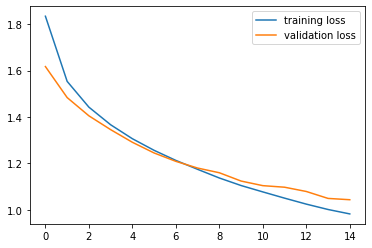

In [36]:
'''
  the training loss became less than validation loss, causing overfitting
  (Overfitting means that the neural network models the training data too well and fails when it faces new and yet unseen data)
'''
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

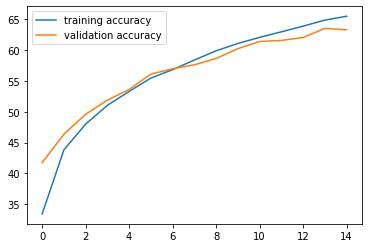

In [37]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

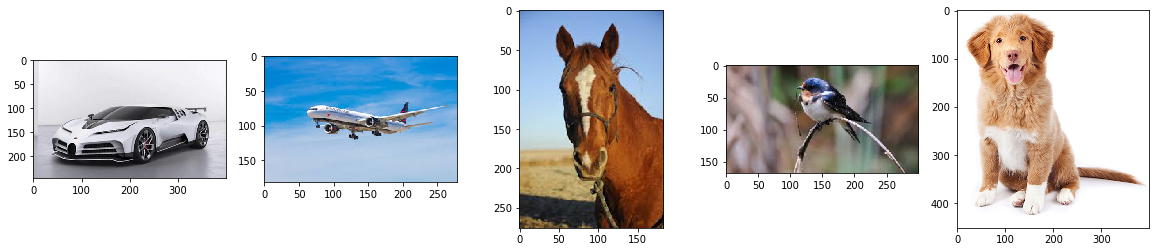

In [15]:
import PIL.ImageOps
import requests
from PIL import Image

urls = ['https://i.postimg.cc/Xqz797Ws/bugatti.jpg', 
        'https://i.postimg.cc/QCtdBK2B/download.jpg',
        'https://i.postimg.cc/NGJ03bXR/images.jpg',
        'https://i.postimg.cc/SsVKNfvF/images-1.jpg',
        'https://i.postimg.cc/CLRKSDCX/welcome.jpg']

columns = len(urls)
imgs = []

fig = plt.figure(figsize=(20, 4))

for idx in range(0, columns):
  response = requests.get(urls[idx], stream = True)
  img = Image.open(response.raw)
  fig.add_subplot(1, columns, idx+1)
  imgs.append(img)
  plt.imshow(img)

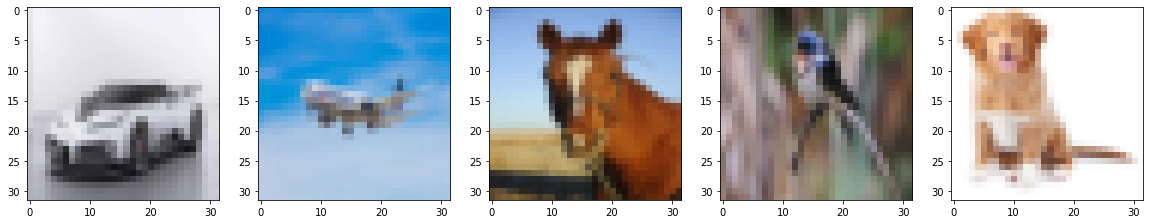

In [20]:
transformed_imgs = []
fig = plt.figure(figsize=(20, 4))

for idx in range(0, columns):
  img = transform(imgs[idx])
  transformed_imgs.append(img)
  fig.add_subplot(1, columns, idx+1)
  plt.imshow(im_convert(img))

In [38]:
for idx in range(0, columns):
  img = transformed_imgs[idx].to(device)
  img = img.unsqueeze(0)
  output = model(img)
  _, pred = torch.max(output, 1)
  print(classes[pred.item()], end=" ")

car plane truck dog cat 

regular results but yet doesn't have good accuracy

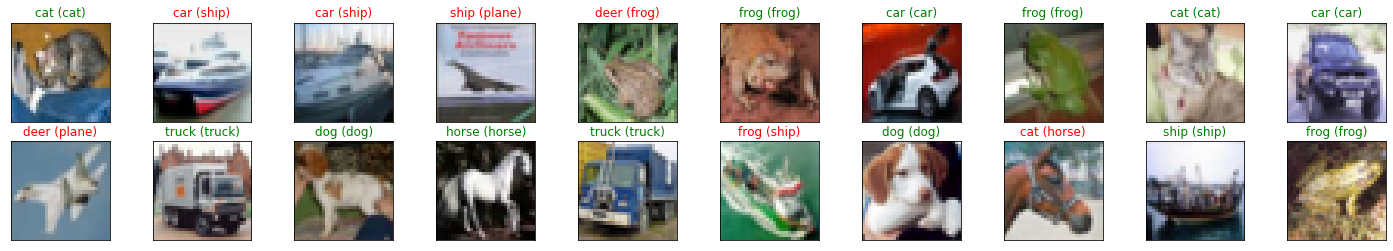

In [39]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))